---
title: 12.1 图像增广
date: 2024-8-11 12:00:00
tags: [机器学习,pytorch]
categories: [机器学习]
comment: true
toc: true
---

#### 

<!--more-->

# 1 图像增广

## 1.1 常用的图像增广方法

- 样例图片: 

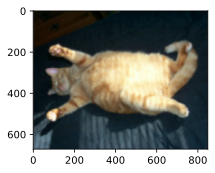

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.Image.open('./img/cat1.jpg')
d2l.plt.imshow(img)

- 大多数图像增广方法都具有一定的随机性。为了便于观察图像增广的效果，我们下面定义辅助函数apply, 在输入图像img上多次运行图像增广方法aug并显示所有结果。

In [2]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

### 1.1.1 翻转和裁剪

- 50%的概率水平翻转图像

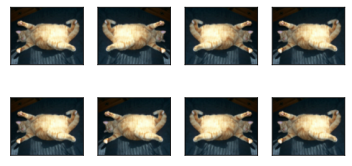

In [3]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

- 50%的概率垂直翻转图像

    - 上下翻转图像不如左右图像翻转那样常用。但是，至少对于这个示例图像，上下翻转不会妨碍识别。

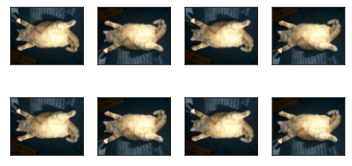

In [4]:
apply(img, torchvision.transforms.RandomVerticalFlip())

- 随机裁剪，使物体以不同的比例出现在图像的不同位置; 汇聚层可以降低卷积层对目标位置的敏感性

- 随机裁剪一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5～2之间随机取值。然后，区域的宽度和高度都被缩放到200像素

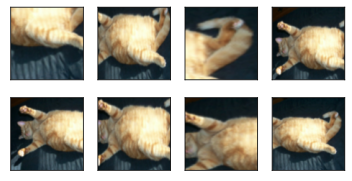

In [5]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### 1.1.2 变化颜色

- 我们可以改变图像颜色的四个方面:

    - 亮度: 调整亮度可以使图像看起来更明亮或更暗

    - 对比度: 增加对比度可使图像中的阴影更加明显

    - 饱和度: 饱和度是指颜色的纯度

    - 色调: 色调是指颜色的个别阴影

- 随机更改图像的亮度，随机值为原始图像的50%（1−0.5）到150%（1+0.5）之间。

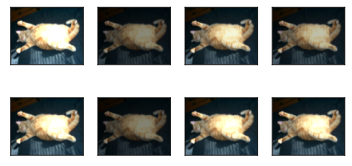

In [6]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

- 随机更改图像的色调。

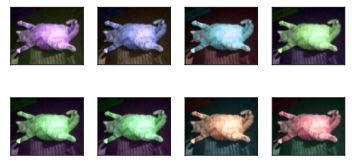

In [7]:
color_aug = torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5)
apply(img, color_aug)

### 1.1.3 组合使用多种图像增广方法

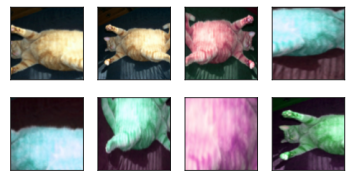

In [8]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

## 1.2 使用图像增广训练模型

- 使用cifar10数据集

Files already downloaded and verified


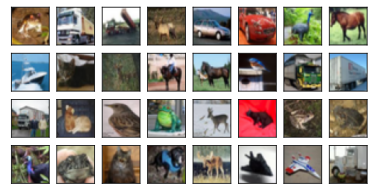

In [9]:
all_images = torchvision.datasets.CIFAR10(train=True, root='./data', download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

- 为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，且在预测过程中不使用随机操作的图像增广。

In [10]:
train_augs = torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()])
test_augs = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()])

# 辅助函数, 便于读取图像和应用图像增广。
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="./data", train=is_train,
    transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

### 1.2.1 多GPU训练


In [11]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            print(epoch, i)
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches- 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[3],None))
            test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
            animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
            f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
            f'{str(devices)}')

- 利用图像增广训练模型.

loss 0.171, train acc 0.941, test acc 0.851
4751.6 examples/sec on [device(type='cuda', index=6)]


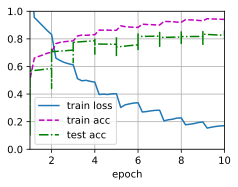

In [12]:
batch_size, devices, net = 256, [torch.device(f'cuda:6')], d2l.resnet18(10, 3)
def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)
# net.to(devices[0])
# net = nn.DataParallel(net, device_ids = devices)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)
train_with_data_aug(train_augs, test_augs, net)